# 5HDB Viz

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.ndimage
import sys
import torch
from PIL import Image
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

sys.path.append('../src')
from vae_lightning_utils import load_vae_model
from ours_lightning_utils import load_our_model
from dataset_utils import get_dataset
from dataset_utils import transform_particles


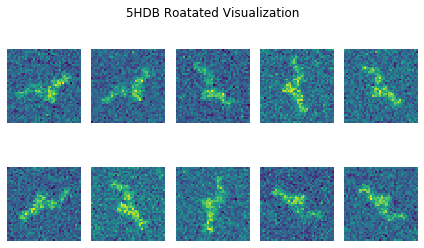

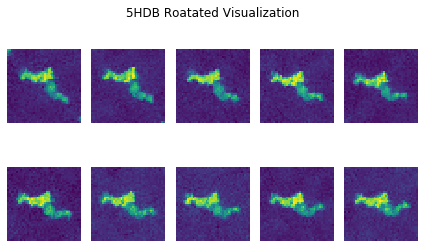

In [2]:
# Load dataset
train_loader, test_loader, image_shape = get_dataset('5hdb', 1, 0, data_base_dir='../data/')

# Visualize dataset
fig, axs = plt.subplots(2, 5)
for ax, i in zip(axs.flatten(), np.linspace(0, len(train_loader.dataset) - 1, 10).astype(int)):
    img, rot, img_rot = train_loader.dataset[i]
    ax.imshow(img.squeeze())
    ax.set_axis_off()
fig.suptitle("5HDB Roatated Visualization")
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2, 5)
for ax, i in zip(axs.flatten(), np.linspace(0, len(train_loader.dataset) - 1, 10).astype(int)):
    img, rot, img_rot = train_loader.dataset[i]
    ax.imshow(img_rot.squeeze())
    ax.set_axis_off()
fig.suptitle("5HDB Roatated Visualization")
plt.tight_layout()
plt.show()


## Inference using VAE

In [3]:
# VAE
out_base_dir = '../output/vae_5hdb_20200619_132545'
vae_model = load_vae_model(out_base_dir, train_loader, test_loader, image_shape)
vae_model = vae_model.eval()

# Ours
ours_base_dir = '../output/ours_5hdb_20200626_150655'
our_model = load_our_model(ours_base_dir, train_loader, test_loader, image_shape)
our_model = our_model.eval()


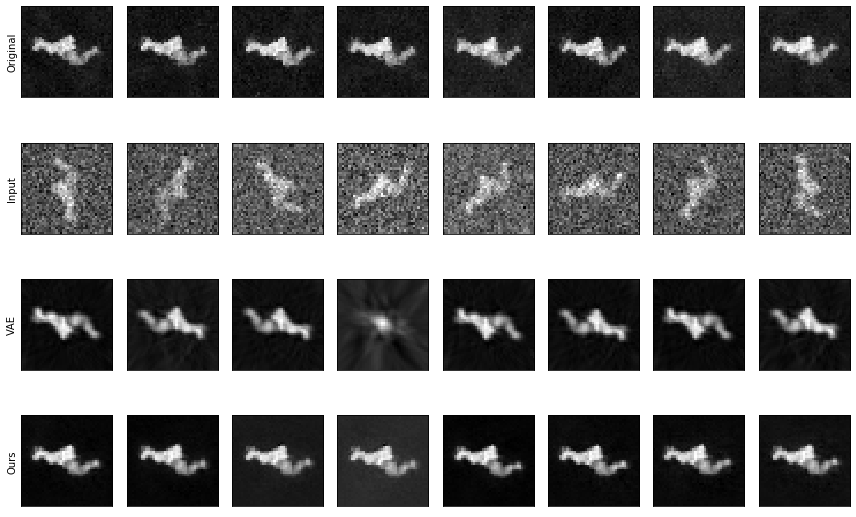

In [4]:
viz_num = 8

viz_idxs = np.linspace(0, len(test_loader.dataset) - 1, viz_num).astype(int)

w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(4, len(viz_idxs), figsize=(w * 2, h * 2), facecolor='w')

for i, idx in enumerate(viz_idxs):
    # Get input and visualize it
    imgs, rot, imgs_rot0 = test_loader.dataset[idx]
    ax = axs[0, i]
    ax.imshow(imgs_rot0.squeeze(), cmap='gray')
    ax = axs[1, i]
    ax.imshow(imgs.squeeze(), cmap='gray')

    # Inference vae
    imgs_vae = vae_model.forward(vae_model.x_coord, imgs, theta_input=0)[0].detach().numpy()
    ax = axs[2, i]
    ax.imshow(np.flip(imgs_vae.squeeze(), axis=1), cmap='gray')

    # Inference ours
    z_rot_input = torch.zeros(len(imgs), 1)  # Force the decoder to generate images with rotation zero
    gen_imgs, z_rot = our_model.forward(imgs, z_rot_input=z_rot_input)
    gen_imgs = gen_imgs.detach().numpy()
    ax = axs[3, i]
    ax.imshow(gen_imgs.squeeze(), cmap='gray')

[ax.set_xticks([]) for ax in axs.flatten()]
[ax.set_yticks([]) for ax in axs.flatten()]

axs[0, 0].set_ylabel('Original')
axs[1, 0].set_ylabel('Input')
axs[2, 0].set_ylabel('VAE')
axs[3, 0].set_ylabel('Ours')

plt.tight_layout()
plt.show()


## Verify dataset statistics

In [5]:
# calc numpy dataset statistics
imgs = np.load('../data/5HDB/processed_train.npy')
print(imgs.mean(), imgs.std(), imgs.max(), imgs.min())

# Calc dataset mean and std
img_list = [img for img, _, _ in train_loader.dataset]
img_tensor = torch.cat(img_list, 0)
print(img_tensor.mean(), img_tensor.std(), img_tensor.max(), img_tensor.min())


0.9820243 2.3510475 14.401253 -5.6437025
tensor(0.9822) tensor(2.3510) tensor(16.0992) tensor(-8.7009)


# Animation

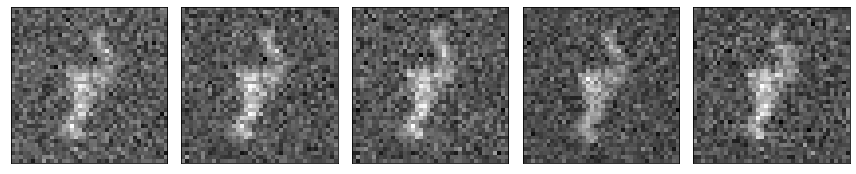

In [6]:
# Get input and visualize it
idx = 10
img = test_loader.dataset.imgs_rot[idx]

img_inputs = []
for angle in np.arange(0, 360, 1):
    img_rot = scipy.ndimage.rotate(img, angle, mode='reflect')
    img_input = transform_particles(Image.fromarray(img_rot, mode='P'))
    img_inputs.append(img_input)

# visualize
w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(1, 5, figsize=(w * 2, h), facecolor='w')
for i, ax in enumerate(axs):
    ax.imshow(img_inputs[i].squeeze(), cmap='gray')
[ax.set_xticks([]) for ax in axs.flatten()]
[ax.set_yticks([]) for ax in axs.flatten()]
plt.tight_layout()
plt.show()


100%|██████████| 360/360 [00:04<00:00, 76.31it/s]


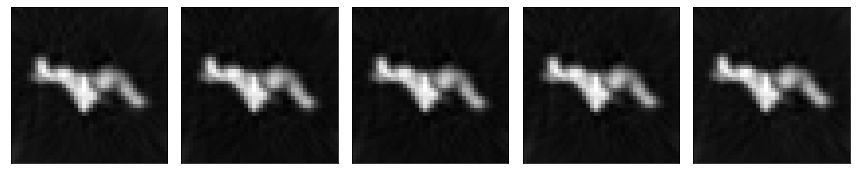

In [7]:
# Inference vae
vae_imgs = []
for img in tqdm(img_inputs):
    vae_img = vae_model.forward(vae_model.x_coord, img, theta_input=0)[0].detach().numpy()
    vae_img = np.flip(vae_img.squeeze(), axis=1)
    vae_imgs.append(vae_img)

# visualize
w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(1, 5, figsize=(w * 2, h), facecolor='w')
for i, ax in enumerate(axs):
    ax.imshow(vae_imgs[i].squeeze(), cmap='gray')
[ax.set_xticks([]) for ax in axs.flatten()]
[ax.set_yticks([]) for ax in axs.flatten()]
plt.tight_layout()
plt.show()


100%|██████████| 360/360 [00:00<00:00, 492.90it/s]


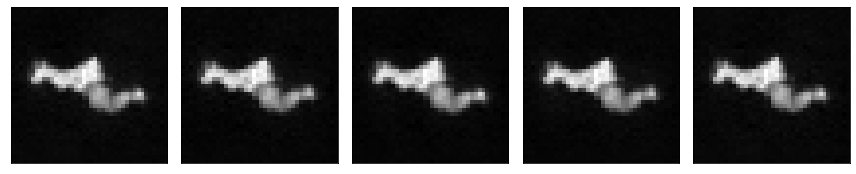

In [8]:
# Inference ours
our_imgs = []
z_rot_input = torch.zeros(len(img), 1)  # Force the decoder to generate images with rotation zero
for img in tqdm(img_inputs):
    our_img, z_rot = our_model.forward(img, z_rot_input=z_rot_input)
    our_img = our_img.detach().numpy().squeeze()
    our_imgs.append(our_img)

# visualize
w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(1, 5, figsize=(w * 2, h), facecolor='w')
for i, ax in enumerate(axs):
    ax.imshow(our_imgs[i].squeeze(), cmap='gray')
[ax.set_xticks([]) for ax in axs.flatten()]
[ax.set_yticks([]) for ax in axs.flatten()]
plt.tight_layout()
plt.show()


100%|██████████| 361/361 [00:14<00:00, 20.32it/s]

Finish


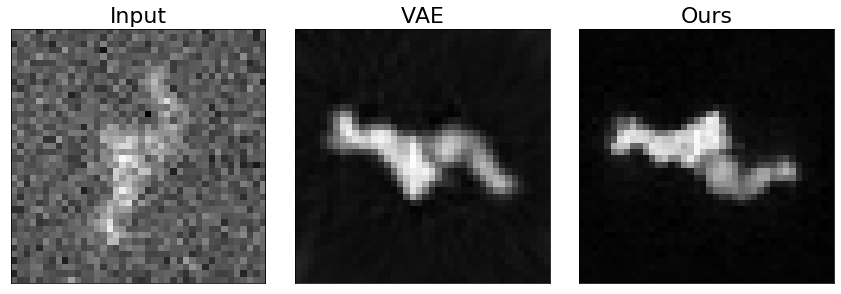

In [9]:
# Define outputs
out_dir = '../output/animations'
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'roation_animation.mp4')

w, h = plt.rcParams.get('figure.figsize')
fig, axs = plt.subplots(1, 3, figsize=(w * 2, h), sharex=True, sharey=True)
ax = axs[0]
im0 = ax.imshow(img_inputs[0].squeeze(), cmap='gray')
ax.set_title('Input', size=22)
ax = axs[1]
im1 = ax.imshow(vae_imgs[0].squeeze(), cmap='gray')
ax.set_title('VAE', size=22)
ax = axs[2]
im2 = ax.imshow(our_imgs[0].squeeze(), cmap='gray')
ax.set_title('Ours', size=22)
[ax.set_xticks([]) for ax in axs.flatten()]
[ax.set_yticks([]) for ax in axs.flatten()]
fig.tight_layout()

pbar = tqdm(total=len(img_inputs) + 1)

def update(frame):
    im0.set_data(img_inputs[frame].squeeze())
    im1.set_data(vae_imgs[frame].squeeze())
    im2.set_data(our_imgs[frame].squeeze())
    pbar.update()
    return im0, im1, im2

anim = FuncAnimation(fig, update, frames=len(img_inputs), blit=True)
anim.save(out_path, fps=33, extra_args=['-vcodec', 'libx264'])

print('Finish')
